Test notebook to demonstrate how to open individual files and plot variables without using Coffea. Useful for simple studies.

In [6]:
import uproot
import vector
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

In [16]:
#Fill in the path to individual ffNtuple files here
file_path = "SIDM/Student_Notebooks/"
file_names  = ["ffNtuple_2Mu2E_500_1p2_9p6.root","ffNtuple_2Mu2E_200_1p2_4p8.root","ffNtuple_2Mu2E_500_5_40.root"]

branches_dict = {}

for file_name in file_names:
    print("Opening ",file_path+file_name)
    temp_file = uproot.open(file_path+file_name)
    tree = temp_file['ffNtuplizer/ffNtuple']
    #Load all the branches into memory and store in branches_dict (this is slow, and could be done in a 
    #"lazy" way to only read the arrays that we end up using, but I'm too lazy to be lazy)
    branches_dict[file_name] = tree.arrays()

Opening  SIDM/Student_Notebooks/ffNtuple_2Mu2E_500_1p2_9p6.root
Opening  SIDM/Student_Notebooks/ffNtuple_2Mu2E_200_1p2_4p8.root
Opening  SIDM/Student_Notebooks/ffNtuple_2Mu2E_500_5_40.root


In [17]:
#Explore the branches in the files
tree.keys("muon_*")

['muon_n',
 'muon_p4',
 'muon_p4/muon_p4.fCoordinates.fX',
 'muon_p4/muon_p4.fCoordinates.fY',
 'muon_p4/muon_p4.fCoordinates.fZ',
 'muon_p4/muon_p4.fCoordinates.fT',
 'muon_charge',
 'muon_type',
 'muon_bestTrackType',
 'muon_selectors',
 'muon_hasInnerTrack',
 'muon_hasOuterTrack',
 'muon_d0',
 'muon_d0Sig',
 'muon_dz',
 'muon_dzSig',
 'muon_normChi2',
 'muon_dtCscTime',
 'muon_rpcTime',
 'muon_isoValue',
 'muon_simType']

Processing  ffNtuple_2Mu2E_500_1p2_9p6.root
Processing  ffNtuple_2Mu2E_200_1p2_4p8.root
Processing  ffNtuple_2Mu2E_500_5_40.root


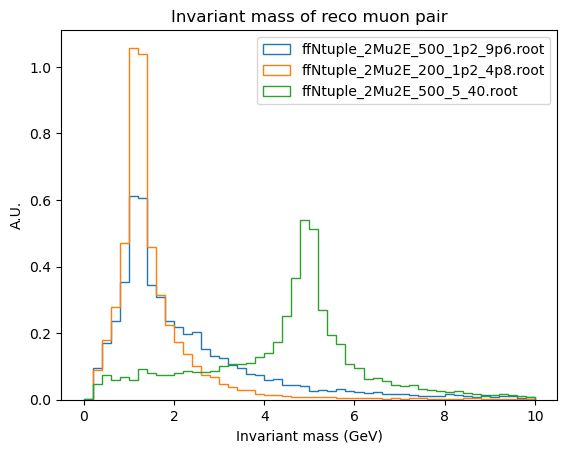

In [18]:
#Plot the invariant mass of the reconstructed muon pair (should peak at the dark photon mass)

for file_name in file_names:
    print("Processing ",file_name)
    branches = branches_dict[file_name]
    
    #Create a vector object for the muons
    muon_p4 = vector.zip({"px": branches['muon_p4.fCoordinates.fX'],
                          "py": branches['muon_p4.fCoordinates.fY'],
                          "pz": branches['muon_p4.fCoordinates.fZ'],
                          "t": branches['muon_p4.fCoordinates.fT']})
    
    #Apply quality cuts to muons (could add more here)
    good_muon_mask = (muon_p4.pt > 5) & (abs(muon_p4.eta) < 2.4) #muon level mask
    
    #Apply the mask
    good_muons = muon_p4[good_muon_mask]
    
    #Select events with at least two good muons
    two_muons_mask = ak.count(good_muons.pt,1) >= 2 #event level mask
    two_muons_p4 = good_muons[two_muons_mask]
    
    first_muon_p4 = two_muons_p4[:, 0]
    second_muon_p4 = two_muons_p4[:, 1]
    muon_sum_p4 = first_muon_p4 + second_muon_p4 #event level quantity
    two_muons_charges = branches['muon_charge'][two_muons_mask]
    opposite_sign_muons_mask = two_muons_charges[:, 0] != two_muons_charges[:, 1] #event level mask
    dimuon_p4 = muon_sum_p4[opposite_sign_muons_mask]
    plt.hist(dimuon_p4.mass, bins=50, range=(0, 10), label = file_name,histtype='step',density=True)
plt.xlabel('Invariant mass (GeV)')
plt.ylabel('A.U.')
plt.title('Invariant mass of reco muon pair')
plt.legend(loc = 'upper right')

Processing  ffNtuple_2Mu2E_500_1p2_9p6.root
Processing  ffNtuple_2Mu2E_200_1p2_4p8.root
Processing  ffNtuple_2Mu2E_500_5_40.root


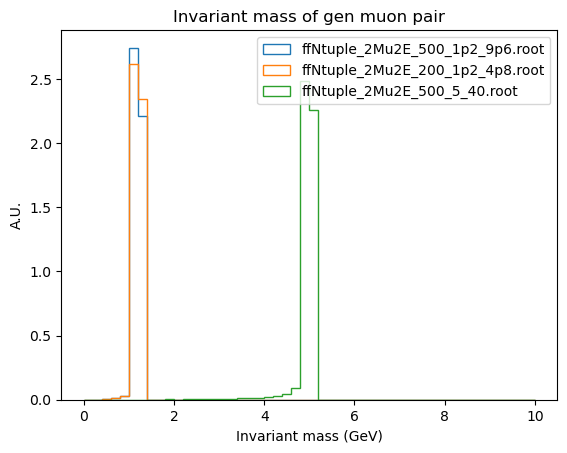

In [19]:
#Plot the invariant mass of the gen muon pair (should peak at the dark photon mass)

for file_name in file_names:
    print("Processing ",file_name)
    branches = branches_dict[file_name]
    
    #Create a vector object for the gen particles
    gen_p4 = vector.zip({"px": branches['gen_p4.fCoordinates.fX'],
                          "py": branches['gen_p4.fCoordinates.fY'],
                          "pz": branches['gen_p4.fCoordinates.fZ'],
                          "t": branches['gen_p4.fCoordinates.fT']}  )
    
    #Select gen muons 
    # (since we are using gen muons and the 2Mu2E files, we are guaranteed to have exactly 2 muons per event)
    gen_muon_mask = abs(branches["gen_pid"]) == 13
    gen_muon_p4 = gen_p4[gen_muon_mask]

    gen_muon_sum_p4 = gen_muon_p4[:, 0] + gen_muon_p4[:, 1]   

    plt.hist(gen_muon_sum_p4.mass, bins=50, range=(0, 10), label = file_name,histtype='step',density=True)
plt.xlabel('Invariant mass (GeV)')
plt.ylabel('A.U.')
plt.title('Invariant mass of gen muon pair')
plt.legend(loc = 'upper right')